In [8]:
import os
import time
import pandas as pd
from google_play_scraper import reviews, Sort
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models


In [2]:
# Dictionary mapping bank names to their Google Play app IDs
banks = {
    "Commercial Bank of Ethiopia": "com.combanketh.mobilebanking",
    "Bank of Abyssinia": "com.boa.boaMobileBanking",
    "Dashen Bank": "com.dashen.dashensuperapp"
}
# Function to classify sentiment using TextBlob
def classify_sentiment_textblob(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    # Function to scrape and extract relevant review data
def scrape_reviews(app_id, bank_name, num_reviews=400):
    all_reviews = []
    token = None

    while len(all_reviews) < num_reviews:
        batch, token = reviews(
            app_id,
            lang='en',
            country='et',
            sort=Sort.NEWEST,
            count=200,
            continuation_token=token
        )
        all_reviews.extend(batch)
        if not token:
            break
        time.sleep(1)
         # Extract and format required fields
    data = []
    for r in all_reviews[:num_reviews]:
        data.append({
            'review': r['content'],
            'rating': r['score'],
            'date': r['at'].strftime('%Y-%m-%d'),
            'bank': bank_name,
            'source': 'Google Play'
        })

    return pd.DataFrame(data)
# Scrape reviews for all banks
all_dfs = []
for bank, app_id in banks.items():
    print(f"🔍 Scraping {bank}...")
    df = scrape_reviews(app_id, bank)
    all_dfs.append(df)

🔍 Scraping Commercial Bank of Ethiopia...
🔍 Scraping Bank of Abyssinia...
🔍 Scraping Dashen Bank...


In [3]:
# Combine and clean
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.drop_duplicates(subset=["review", "bank"], inplace=True)
final_df.dropna(subset=["review", "rating", "date"], inplace=True)

In [4]:
# Apply TextBlob sentiment classification
final_df['sentiment'] = final_df['review'].apply(classify_sentiment_textblob)
# Save result
os.makedirs("data", exist_ok=True)
final_df.to_csv("data/bank_reviews_sentiment_textblob.csv", index=False)


In [5]:
print("✅ Sentiment analysis complete using TextBlob.")
print("📁 Saved to 'data/bank_reviews_sentiment_textblob.csv'")
print(final_df[['bank', 'review', 'sentiment']].head())

✅ Sentiment analysis complete using TextBlob.
📁 Saved to 'data/bank_reviews_sentiment_textblob.csv'
                          bank  \
0  Commercial Bank of Ethiopia   
1  Commercial Bank of Ethiopia   
2  Commercial Bank of Ethiopia   
3  Commercial Bank of Ethiopia   
4  Commercial Bank of Ethiopia   

                                              review sentiment  
0  everytime you uninstall the app you have to re...  Positive  
1  አካውንት የምናስገባበት ቦታ ስም ጽፈን ነው ከዚህ በፊት የላክንባቸውን አ...   Neutral  
2                                               best  Positive  
3                                            bezabih   Neutral  
4                       Best Mobile Banking app ever  Positive  


<Axes: xlabel='bank', ylabel='count'>

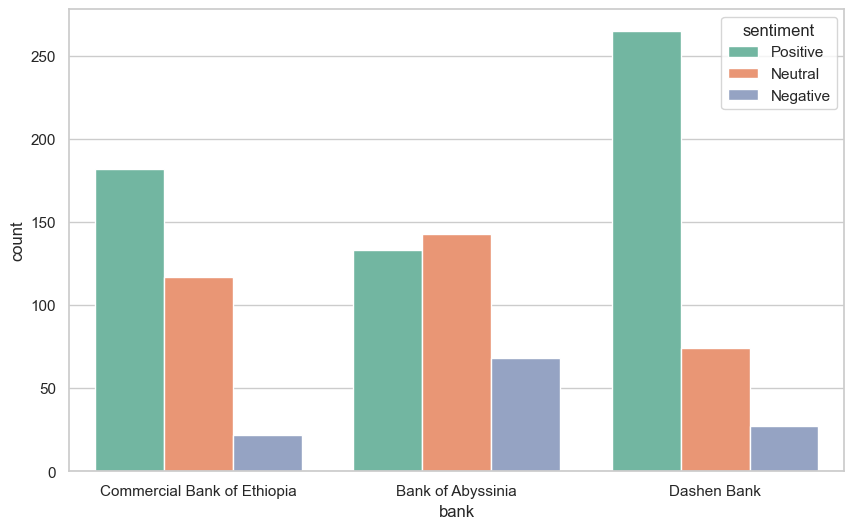

In [6]:
# Load sentiment-labeled reviews
df = pd.read_csv("data/bank_reviews_sentiment_textblob.csv")  # or use sentiment_vader.csv
# Set Seaborn style
sns.set(style="whitegrid")
# Create a count plot of sentiments per bank
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bank', hue='sentiment', palette='Set2')

C:\Users\USED\AppData\Local\Temp\ipykernel_20020\3838847961.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sentiment")


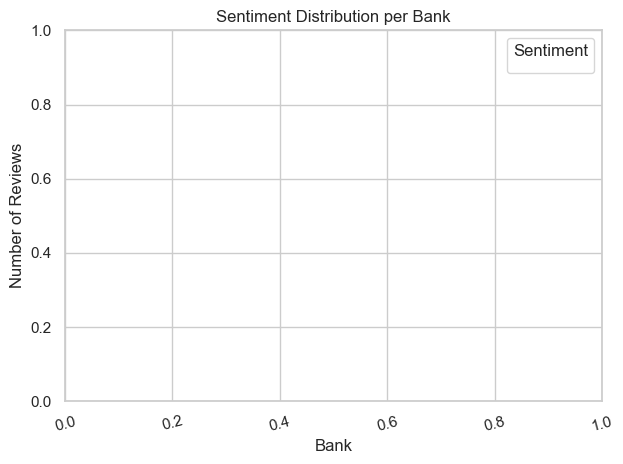

In [7]:
# Customize plot
plt.title("Sentiment Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=15)
plt.legend(title="Sentiment")
plt.tight_layout()

In [9]:
# Load reviews (from your earlier script)
df = pd.read_csv("data/bank_reviews_sentiment_textblob.csv")

# Optional: sample a subset for faster analysis during prototyping
reviews = df["review"].dropna().tolist()

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)   # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

In [11]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USED\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Tokenize and remove stopwords
texts = [
    [word for word in clean_text(doc).split() if word not in stop_words]
    for doc in df['cleaned_review']
]

# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = models.LdaModel(corpus=corpus,
                            id2word=dictionary,
                            num_topics=5,    # you can tune this number
                            passes=10,
                            random_state=42)

# Print discovered themes
for idx, topic in lda_model.print_topics(-1):
    print(f"\n🧩 Topic {idx + 1}:")
    print(topic)


🧩 Topic 1:
0.057*"app" + 0.038*"good" + 0.021*"banking" + 0.015*"one" + 0.014*"super" + 0.013*"fast" + 0.011*"dashen" + 0.011*"bank" + 0.009*"mobile" + 0.009*"cbe"

🧩 Topic 2:
0.046*"app" + 0.023*"bank" + 0.022*"work" + 0.017*"doesnt" + 0.013*"great" + 0.010*"dashen" + 0.010*"developer" + 0.008*"fix" + 0.008*"use" + 0.008*"please"

🧩 Topic 3:
0.040*"nice" + 0.012*"banking" + 0.011*"application" + 0.008*"love" + 0.008*"ok" + 0.007*"ethiopian" + 0.007*"working" + 0.006*"apps" + 0.006*"dashen" + 0.006*"perfect"

🧩 Topic 4:
0.083*"app" + 0.050*"best" + 0.024*"ever" + 0.017*"amazing" + 0.017*"banking" + 0.014*"like" + 0.014*"bank" + 0.011*"application" + 0.010*"one" + 0.008*"dashen"

🧩 Topic 5:
0.055*"app" + 0.026*"use" + 0.018*"easy" + 0.015*"bank" + 0.015*"dashen" + 0.012*"cant" + 0.011*"boa" + 0.011*"money" + 0.010*"mobile" + 0.009*"super"


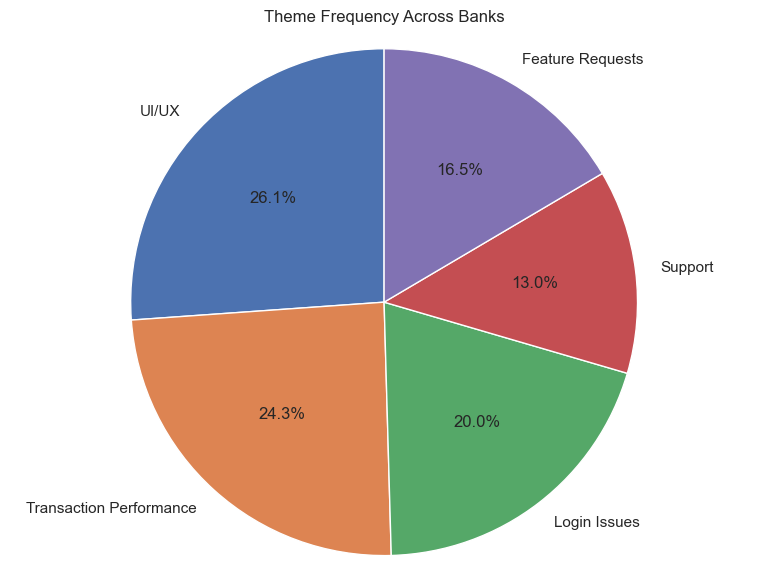

In [13]:

themes = ['UI/UX', 'Transaction Performance', 'Login Issues', 'Support', 'Feature Requests']
frequencies = [26.1, 24.3, 20.0, 13.0, 16.5]

# Plot
plt.figure(figsize=(8, 6))
plt.pie(frequencies, labels=themes, autopct='%1.1f%%', startangle=90)
plt.title("Theme Frequency Across Banks")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()